In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

In [ ]:
#code to set up the model
from pyomo.environ import * 
from pyomo.opt import SolverStatus, TerminationCondition
import sys
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd

## Definição Conjuntos
* mesas = Conjunto de mesas disponíveis para os trabalhadores;
* trabalhadores = Conjunto de nomes de trabalhadores;
* horas = Conjunto de horas disponíveis para os alocação de mesas;
* Dias = Conjunto de dias disponíveis para realização do trabalho;

In [ ]:

model = AbstractModel()
model.mesas = Set()
model.trabalhadores = Set()
model.horas = Set()
model.dias = Set()


## Parametros
1. max_pessoas_lab = Número de pessoas que podem estar no laborátorio, no dia D, na hora H;
2. max_trabalhadores_mesa = Número de pessoas que podem estár em uma mésa;
3. Horas escolhidas = Atribui 1, para as horas escolhidas por um trabalhador, na hora H e no dia D;
4. mesas_trabalhador = Atribui os trabalhadores para a sua respectiva mesa;
5. max_horas = Maximo de horas que um funcionário podem estar na sua mesa;
6. min_horas = Minimo de horas que um funcionário podem estar na sua mesa;
7. primeira_hora = Horario que os funcionarios podem iniciar o seu trabalho;
8. ultima_hora = Ultimo horario que o funcionario podem trabalhar;
10. hr_c_abertura = Hora de abertura em horario comercial;
11. hr_c_fechamento = Hora de fechamento do horario comercial;
12. hr_nc_abertura = Hora de abertura em horario fora comercial;
13. hr_nc_fechamento = Hora de fechamento em horario nao comercial;

In [ ]:

model.max_pessoas_lab = Param(model.horas, model.dias)
model.max_trabalhadores_mesa = Param()
model.horas_escolhidas = Param(model.trabalhadores, model.horas, model.dias, mutable = True, initialize = 0)
model.mesas_trabalhador = Param(model.trabalhadores, model.mesas)
model.max_horas = Param()
model.min_horas = Param()
model.primeira_hora = Param()
model.ultima_hora = Param()
model.hr_c_abertura = Param()
model.hr_c_fechamento = Param()
model.hr_nc_abertura = Param()
model.hr_nc_fechamento = Param() 


In [ ]:
model.x = Var(model.mesas, model.trabalhadores, model.horas, model.dias, within=Binary) 

## $ Maximizar\;Horas\;Escolhidas\;=\sum_{i \in MESAS} \sum_{j \in TRABALHADORES} \sum_{k \in HORAS} \sum_{h \in DIA} mesasTrabalhador_{ji}*horasEscolhidas_{jhk}*x_{ijkh}\; (Eq.1)$ 

In [ ]:
def funcao_objetivo(model):
  """
    Maximizar as horas escolhidas para trabalhar pelos funcionários
  """
  return sum(model.mesas_trabalhador[j,i] * model.horas_escolhidas[j,k,h] * model.x[i,j,k,h] for i in model.mesas for j in model.trabalhadores for k in model.horas for h in model.dias)
model.maximiza_horas_escolhidas = Objective(rule=funcao_objetivo,sense=maximize)

## Restrições

### $\sum_{i \in MESAS}\sum_{j \in TRABALHADORES}x_{ijkh} = maximo pessoas lab{kh}\;\;\;\forall \;k \in\; HORAS,\;\forall \;h \in\; DIA\; (Eq. 2)$
### $\sum_{j \in TRABALHADORES}x_{ijkh} = pessoas atribuidas mesa\;\forall i \in\; MESA,\; \forall \;k \in\; HORAS,\;\forall \;h \in\; DIA\;(Eq. 3)$


In [ ]:
def maximo_pessoas_lab(model, hora, dia):
  """
  Restrição de alocação do laboratorio com base na hora e no dia.
  As restrições de capacidade garantem que haja 
  apenas uma pessoa em um cubo de cada vez e que o número 
  total de pessoas no edifício esteja dentro ou abaixo do limite permitido.
  Eq.2
  """
  return (sum(model.x[c,t,hora,dia] for c in model.mesas for t in model.trabalhadores) <= model.max_pessoas_lab[hora, dia])

def pessoas_atribuiadas_a_mesa(model, mesa, hora, dia):
  """
  Restricao de Alocacao a trabalhadores em uma mesa, deve ser 1. (Eq.3)
  """
  return (sum(model.x[mesa,t,hora,dia] for t in model.trabalhadores) <= model.max_trabalhadores_mesa)
  

In [ ]:
model.max_pessoas_lab_restricao = Constraint(model.horas, model.dias, rule = maximo_pessoas_lab)

In [ ]:
model.pessoas_atribuiadas_a_mesa_restricao = Constraint(model.mesas, model.horas, model.dias, rule=pessoas_atribuiadas_a_mesa)


### $\sum_{i \in MESAS}\sum_{k \in HORAS}\sum_{h \in DIAS}x_{ijkh} >= min Horas por Semana \;\forall \;j \in\; TRABALHADORES\; (Eq. 4)$



In [ ]:
def min_horas_por_semana(model, trabalhadores):
  """
    Restricao que determina que o funcionario nao tenha o minimo de horas
    Eq. 5
  """
  dias_comerciais = ['Segunda','Terca','Quarta','Quinta','Sexta']
  for dia in model.dias:
    for hora in model.horas:
      if dia in dias_comerciais:
        if (hora >= model.hr_c_abertura) and  (hora <= model.hr_c_fechamento):
          return (sum(model.x[computador,trabalhadores,h,d] for computador in model.mesas for h in model.horas for d in model.dias) >= model.min_horas)
        elif (hora >= model.hr_nc_abertura) and (hora  <= model.hr_nc_fechamento):
          return (sum(model.x[computador,trabalhadores,h,d] for computador in model.mesas for h in model.horas for d in model.dias) >= model.min_horas)
      else:
        return (sum(model.x[computador,trabalhadores,h,d] for computador in model.mesas for h in model.horas for d in model.dias) >= model.min_horas)



### $\sum_{i \in MESAS}\sum_{k \in HORAS}\sum_{h \in DIAS}x_{ijkh} <= max Horas por Semana\;\forall \;j \in\; TRABALHADORES\; (Eq. 5)$


In [ ]:

def max_horas_por_semana(model, trabalhadores):
  """
  Restricao  que determina que funcionário não passe do maximo de horas
  Eq.4
  """
  dias_comerciais = ['Segunda','Terca','Quarta','Quinta','Sexta']
  for dia in model.dias:
    for hora in model.horas:
      if dia in dias_comerciais:
        if (hora >= model.hr_c_abertura) and  (hora <= model.hr_c_fechamento):
          return (sum(model.x[computador,trabalhadores,h,d] for computador in model.mesas for h in model.horas for d in model.dias) <= model.max_horas)
        elif (hora >= model.hr_nc_abertura) and (hora <= model.hr_nc_fechamento):
          return (sum(model.x[computador,trabalhadores,h,d] for computador in model.mesas for h in model.horas for d in model.dias) <= model.max_horas)
      else:
        return (sum(model.x[computador,trabalhadores,h,d] for computador in model.mesas for h in model.horas for d in model.dias) <= model.max_horas)

### $x_{ijkh}<=x_{ij(k+1)h}\; \forall i \in\; MESAS,\; \forall \;j \in\; TRABALHADORES,\;\forall \;k \in\; HORAS,\;\forall \;h \in\; DIAS\;(Eq. 6)$

### $x_{ij(k-1)h}+x_{ij(k+1)h}>=x_{ijkh}\; \forall i \in\; MESAS,\; \forall \;j \in\; TRABALHADORES,\;\forall \;k \in\; HORAS,\;\forall \;h \in\; DIAS\;(Eq. 7)$

### $x_{ijkh}<=x_{ij(k-1)h}\; \forall i \in\; MESAS,\; \forall \;j \in\; TRABALHADORES,\;\forall \;k \in\; HORAS,\;\forall \;h \in\; DIAS\;(Eq. 8)$


In [ ]:
def ajusta_horas(model, computador, trabalhador, hora, dia):
  """
    Horarios atribuidos sao consecutivos.
  """
  result = ''
  if hora == 8:
    # Eq 6
    result = model.x[computador, trabalhador, hora, dia] <= model.x[computador, trabalhador, hora, dia]
  elif (hora >= 9) and (hora <= 21):
    # Eq 7
    result = model.x[computador, trabalhador, hora - 1, dia] + model.x[computador, trabalhador, hora + 1, dia] >= model.x[computador, trabalhador, hora, dia]
  else:
    #Eq 8
    result = model.x[computador, trabalhador, hora, dia] <= model.x[computador, trabalhador, hora - 1, dia]
  return result 

In [ ]:
model.max_horas_semana_restricao = Constraint(model.trabalhadores, rule = max_horas_por_semana)
model.min_horas_semana_restricao = Constraint(model.trabalhadores, rule = min_horas_por_semana)
model.ajusta_horas_restricao = Constraint(model.mesas, model.trabalhadores, model.horas, model.dias, rule = ajusta_horas)

## Execução do Modelo

In [ ]:
arquivo = 'dados_final.dat'
data = DataPortal()
data.load(filename = arquivo, model = model)
optimizer = SolverFactory("glpk")
instance = model.create_instance(data)
results = optimizer.solve(instance)

In [ ]:
if results.solver.status == SolverStatus.ok:
  if results.solver.termination_condition == TerminationCondition.optimal:
    print("Solução Ótima encontrada")
    instance.display()
  elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("Modelo Inviável")
  else:
    print(f"Solução: {results.solver.termination_condition}" )
else:
  print(f"Status: {results.solver.status}")

A saída de streaming foi truncada nas últimas 5000 linhas.
              ('MESA_12', 'Sara', 11, 'Sabado') :  None :  0.0 :   0.0
             ('MESA_12', 'Sara', 11, 'Segunda') :  None :  0.0 :   0.0
               ('MESA_12', 'Sara', 11, 'Sexta') :  None : -1.0 :   0.0
               ('MESA_12', 'Sara', 11, 'Terca') :  None :  0.0 :   0.0
             ('MESA_12', 'Sara', 12, 'Domingo') :  None : -1.0 :   0.0
              ('MESA_12', 'Sara', 12, 'Quarta') :  None :  0.0 :   0.0
              ('MESA_12', 'Sara', 12, 'Quinta') :  None :  0.0 :   0.0
              ('MESA_12', 'Sara', 12, 'Sabado') :  None :  0.0 :   0.0
             ('MESA_12', 'Sara', 12, 'Segunda') :  None : -1.0 :   0.0
               ('MESA_12', 'Sara', 12, 'Sexta') :  None :  0.0 :   0.0
               ('MESA_12', 'Sara', 12, 'Terca') :  None :  0.0 :   0.0
             ('MESA_12', 'Sara', 13, 'Domingo') :  None :  0.0 :   0.0
              ('MESA_12', 'Sara', 13, 'Quarta') :  None : -1.0 :   0.0
              ('ME

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
if results.solver.status == SolverStatus.ok:
  if results.solver.termination_condition == TerminationCondition.optimal:
    print("Solução Ótima encontrada")
  elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("Modelo Inviável")
  else:
    print(f"Solução: {results.solver.termination_condition}" )
else:
  print(f"Status: {results.solver.status}")

Solução Ótima encontrada


In [ ]:
pd.set_option("display.max_rows",None)

In [ ]:
resumo = pd.DataFrame()
mesas = pd.DataFrame()
for dia in instance.dias:
  for computador in instance.mesas:
    for trabalhador in instance.trabalhadores:
      for hora in instance.horas:
        if instance.x[computador,trabalhador,hora,dia].value == 1:
          resumo =resumo.append({"Dia":dia,"Hora":hora,"Trabalhador(a)": trabalhador}, ignore_index=  True)
          mesas = mesas.append({"Mesa": computador, "Trabalhador(a)": trabalhador},ignore_index=  True)
  

In [ ]:
mesas = mesas.drop_duplicates(subset = 'Trabalhador(a)')

In [ ]:
mesas = mesas.drop_duplicates()

In [ ]:
mesas_uso_diario = mesas.merge(resumo, on = 'Trabalhador(a)')

In [ ]:
resumo_horas_semanais = resumo.pivot_table(index = ['Trabalhador(a)','Dia'], values = 'Hora',aggfunc = 'count')

In [ ]:
trabalhados_alocados_por_hora = resumo.pivot_table(index = ['Hora','Dia'], values = 'Hora',aggfunc = 'count')

In [ ]:
horas_trabalhadas = resumo.pivot_table(index = ['Trabalhador(a)'],values = 'Hora', aggfunc='count')

In [ ]:
trabalhadores_alocados_por_dia = resumo.pivot_table(index = ['Hora','Dia'], values = 'Dia',aggfunc = 'count')

In [ ]:
trabalhados_alocados_por_hora = trabalhados_alocados_por_hora.reset_index()

In [ ]:
resumo_horas_semanais

Hora
Trabalhador(a) Dia          
Alex           Quarta      8
               Quinta      8
               Segunda     8
               Sexta       8
               Terca       8
Aline          Domingo     4
               Quarta      4
               Quinta      9
               Sabado      6
               Segunda     4
               Sexta       4
               Terca       9
Arthur         Domingo     8
               Quarta      7
               Quinta      4
               Sabado      4
               Segunda     4
               Sexta       3
               Terca       6
Felipe         Domingo     4
               Quarta      3
               Quinta     10
               Sabado      4
               Segunda     7
               Sexta       2
               Terca      10
Flavia         Quarta     11
               Quinta      4
               Segunda    12
               Sexta       9
               Terca       3
Gabriela       Domingo     4
               Quarta      5
               Quinta      4
               Sabado      5
               Segunda     9
               Sexta       9
               Terca       4
Giovanni       Domingo     5
               Quarta      8
               Quinta      6
               Sabado      5
               Segunda     6
               Terca       6
Guto           Domingo     9
               Quarta      7
               Quinta      7
               Sabado      5
               Segunda     1
               Sexta       6
               Terca       4
Isac           Quarta      5
               Quinta     10
               Sabado      6
               Sexta       9
               Terca       8
Jefferson      Quarta      8
               Quinta      9
               Sabado      9
               Segunda     8
               Sexta       2
               Terca       4
Jonathan       Domingo     6
               Quarta      5
               Quinta      8
               Sabado      6
               Segunda     4
               Sexta       4
               Terca       7
Juca           Domingo     2
               Quarta      5
               Quinta      4
               Sabado     16
               Segunda     6
               Terca       3
Livia          Domingo     7
               Quarta      2
               Quinta      7
               Sabado      5
               Segunda     5
               Sexta       6
               Terca       8
Lucas          Domingo     6
               Quinta      4
               Sabado     11
               Segunda     5
               Sexta       6
               Terca       8
Marcos         Domingo     6
               Quarta      5
               Quinta      8
               Sabado      6
               Segunda     4
               Sexta       3
               Terca       8
Orlando        Quarta      4
               Quinta      9
               Sabado     12
               Segunda     3
               Sexta       4
               Terca       8
Patrick        Domingo     6
               Quarta      8
               Quinta      5
               Sabado      6
               Segunda     6
               Sexta       3
               Terca       4
Rayla          Domingo     4
               Quarta      3
               Quinta      6
               Segunda     3
               Sexta       8
               Terca      12
Rebeca         Domingo     6
               Quarta      4
               Quinta      9
               Sabado      2
               Segunda     6
               Terca       9
Roze           Domingo    13
               Quarta      4
               Quinta      8
               Sabado      6
               Segunda     3
               Terca       4
Samara         Quarta      5
               Quinta     13
               Sabado     10
               Sexta       6
               Terca       3
Sara           Domingo     4
               Quarta      9
               Quinta      6
               Segunda    10
               Sexta       5
               Terca  

In [ ]:
horas_trabalhadas

,Hora
Trabalhador(a),
Alex,40
Aline,40
Arthur,36
Felipe,40
Flavia,39
Gabriela,40
Giovanni,36
Guto,39
Isac,38


In [ ]:
mesas_uso_diario = mesas_uso_diario.drop_duplicates()

In [ ]:
mesas_uso_diario

,Mesa,Trabalhador(a),Dia,Hora
0,MESA_01,Arthur,Segunda,13.0
1,MESA_01,Arthur,Segunda,14.0
2,MESA_01,Arthur,Segunda,15.0
3,MESA_01,Arthur,Segunda,16.0
4,MESA_01,Arthur,Terca,17.0
5,MESA_01,Arthur,Terca,18.0
6,MESA_01,Arthur,Terca,19.0
7,MESA_01,Arthur,Terca,20.0
8,MESA_01,Arthur,Terca,21.0
9,MESA_01,Arthur,Terca,22.0


In [ ]:
a = mesas_uso_diario.groupby(["Mesa",'Trabalhador(a)','Dia','Hora']).mean()

In [ ]:
for name, group in mesas_uso_diario.groupby(["Mesa"]):
  print(group)
  break
  

       Mesa Trabalhador(a)      Dia  Hora
0   MESA_01         Arthur  Segunda  13.0
1   MESA_01         Arthur  Segunda  14.0
2   MESA_01         Arthur  Segunda  15.0
3   MESA_01         Arthur  Segunda  16.0
4   MESA_01         Arthur    Terca  17.0
5   MESA_01         Arthur    Terca  18.0
6   MESA_01         Arthur    Terca  19.0
7   MESA_01         Arthur    Terca  20.0
8   MESA_01         Arthur    Terca  21.0
9   MESA_01         Arthur    Terca  22.0
10  MESA_01         Arthur   Quarta   8.0
11  MESA_01         Arthur   Quarta   9.0
12  MESA_01         Arthur   Quarta  10.0
13  MESA_01         Arthur   Quarta  13.0
14  MESA_01         Arthur   Quarta  14.0
15  MESA_01         Arthur   Quarta  15.0
16  MESA_01         Arthur   Quarta  16.0
17  MESA_01         Arthur   Quinta  19.0
18  MESA_01         Arthur   Quinta  20.0
19  MESA_01         Arthur   Quinta  21.0
20  MESA_01         Arthur   Quinta  22.0
21  MESA_01         Arthur    Sexta  14.0
22  MESA_01         Arthur    Sext

In [ ]:
a = mesas_uso_diario.groupby(["Mesa",'Trabalhador(a)','Dia','Hora']).mean().reset_index()

,Mesa,Trabalhador(a),Dia,Hora
0,MESA_01,Arthur,Domingo,8.000000
1,MESA_01,Arthur,Quarta,12.142857
2,MESA_01,Arthur,Quinta,20.500000
3,MESA_01,Arthur,Sabado,12.000000
4,MESA_01,Arthur,Segunda,14.500000


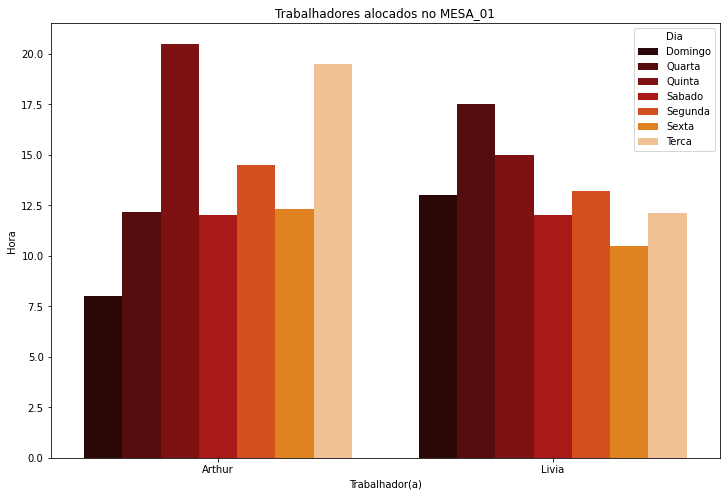

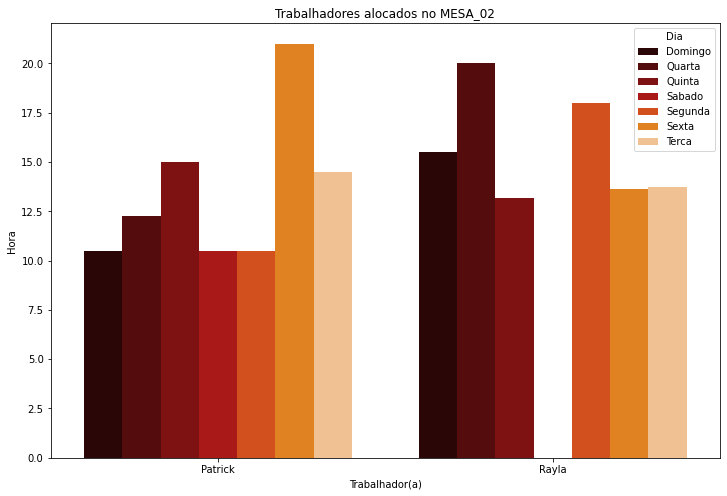

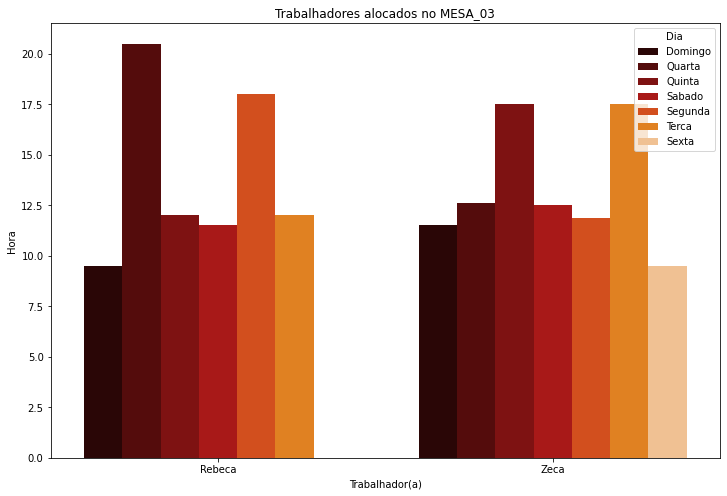

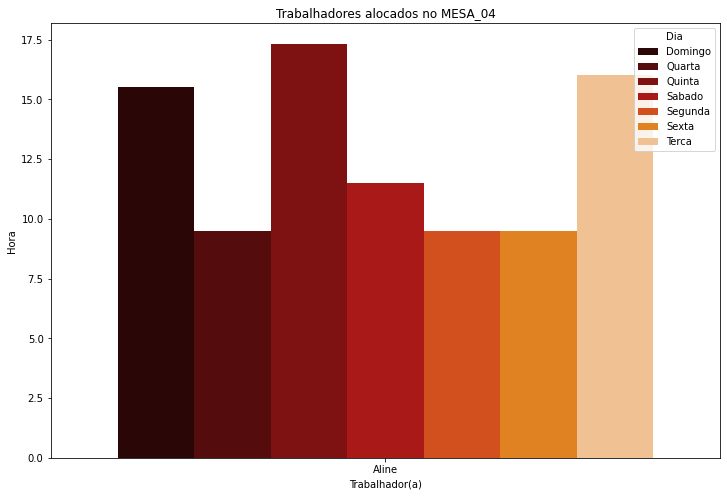

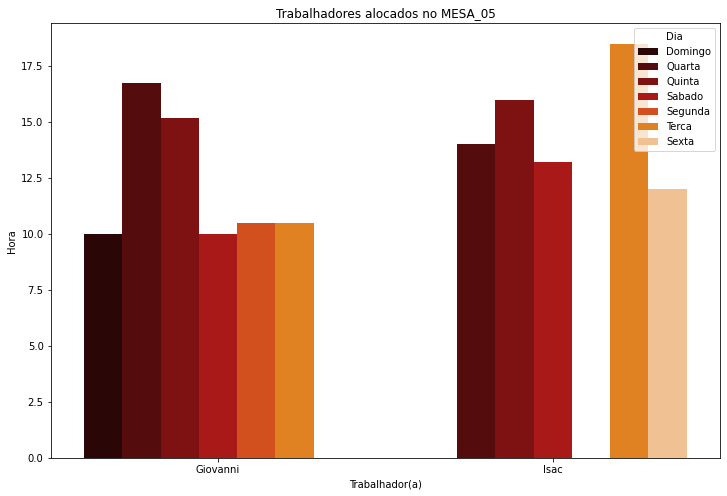

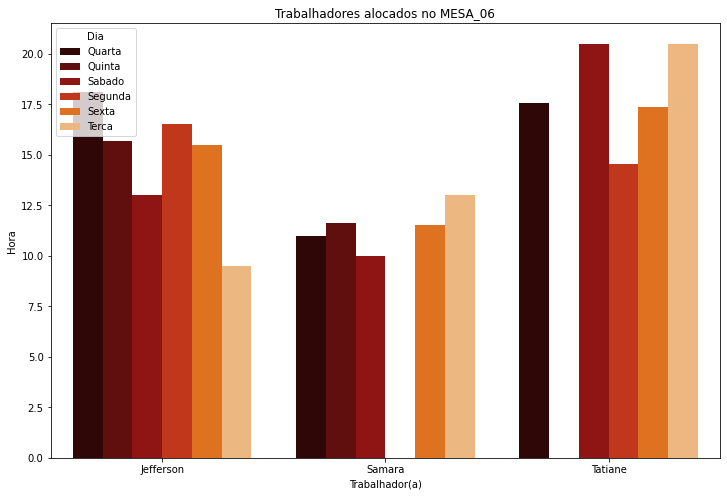

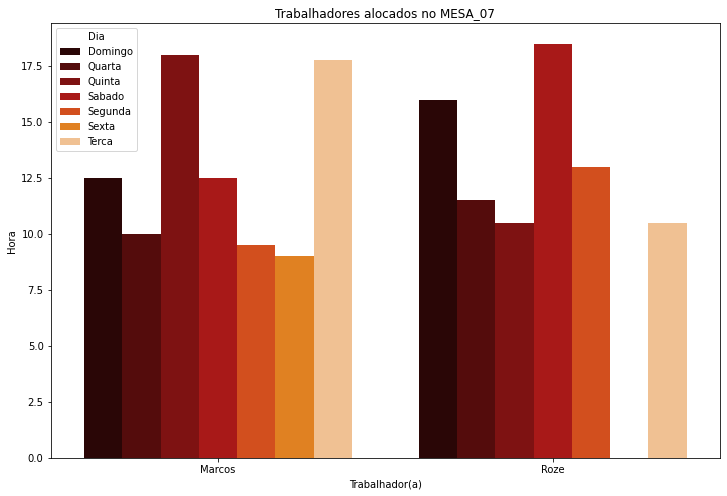

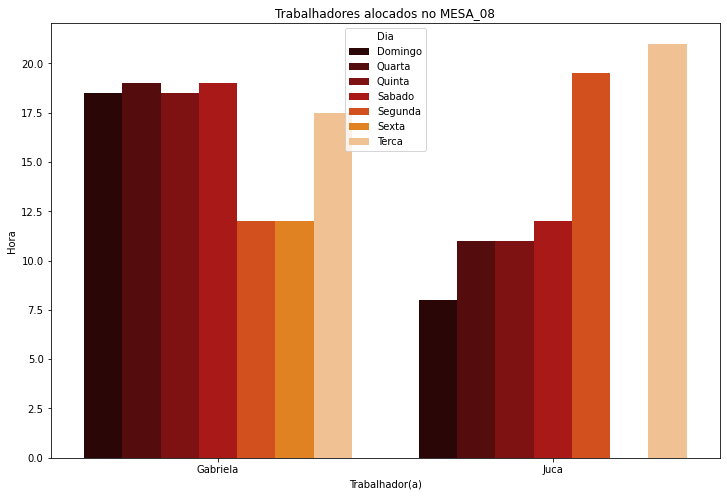

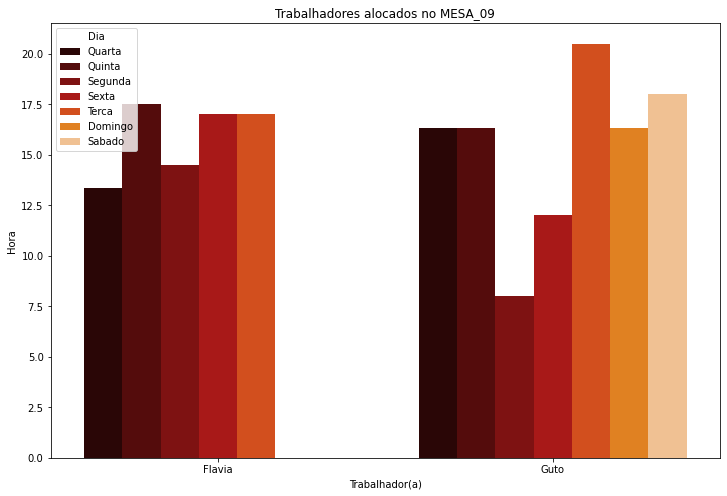

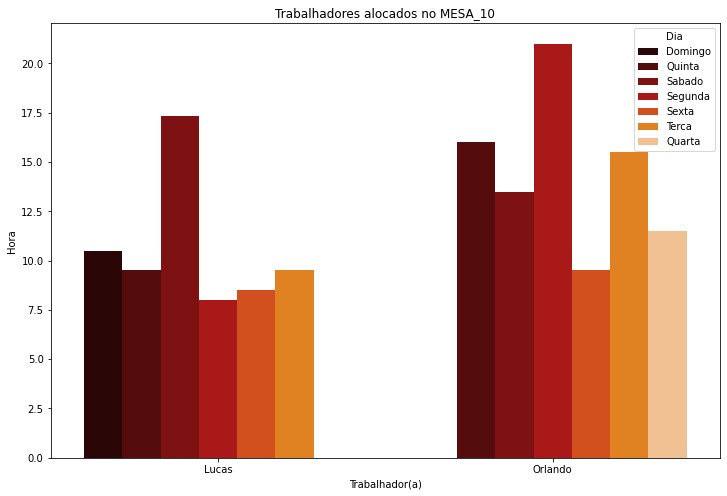

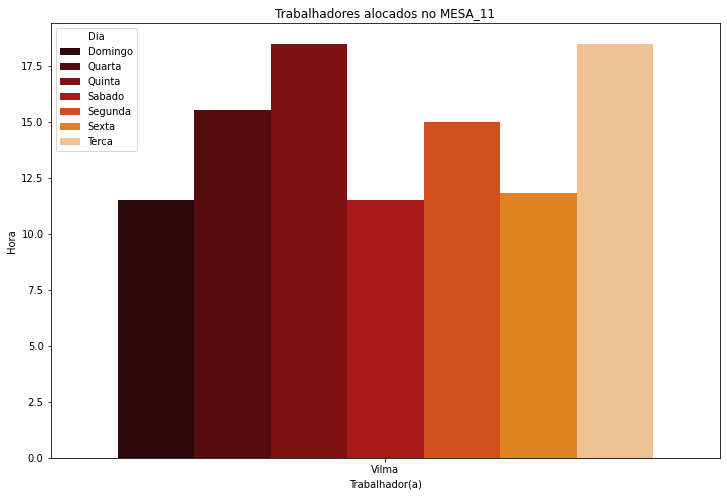

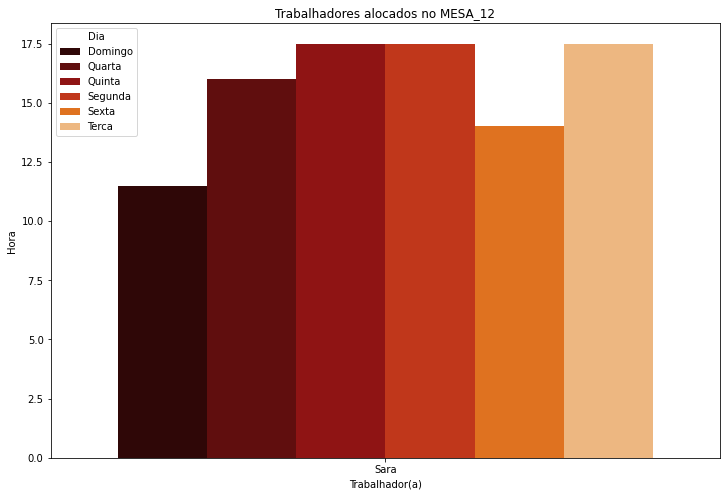

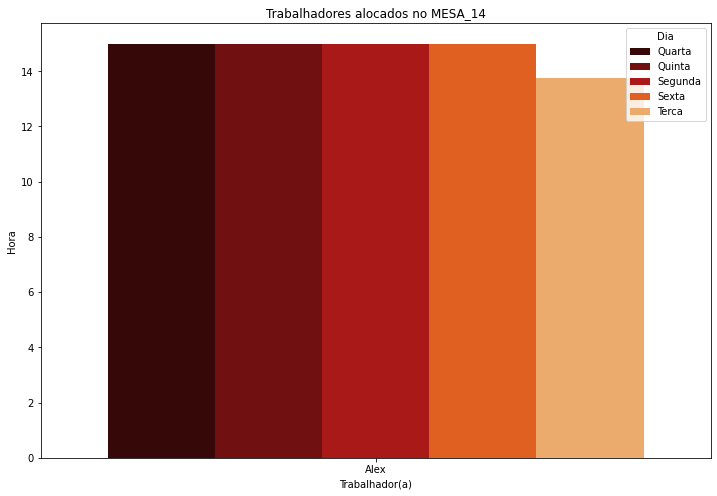

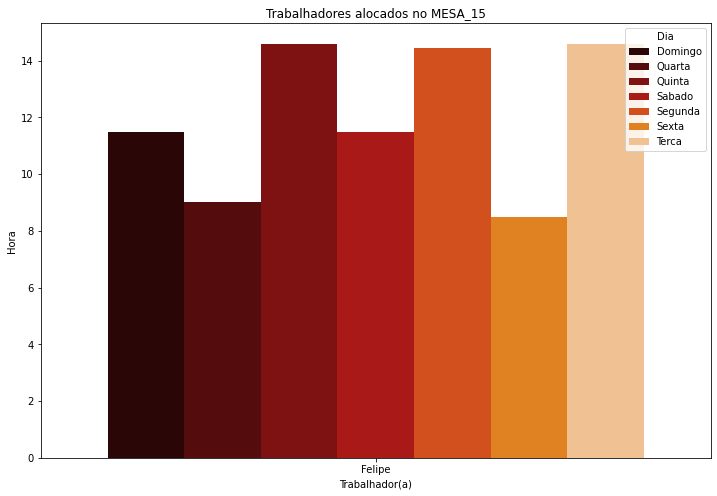

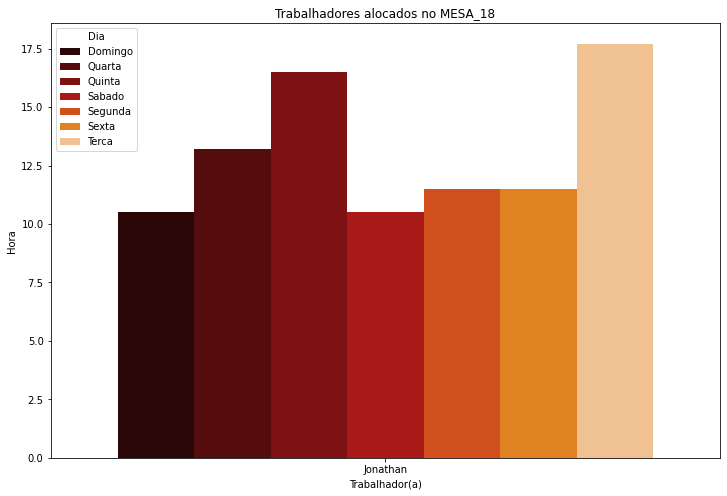

In [ ]:
for mesa in a['Mesa'].unique().tolist():
  aux = a[a['Mesa'] == mesa]
  plt.figure(figsize = (12,8))
  g = sns.barplot(y = 'Hora', x = 'Trabalhador(a)', data = aux, palette = 'gist_heat', hue = 'Dia')
  g.set_title(f"Trabalhadores alocados no {mesa}")
  plt.show()

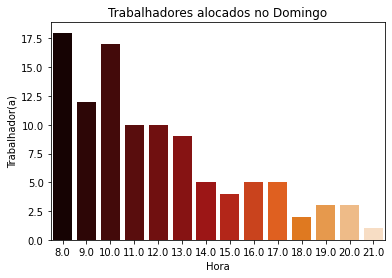

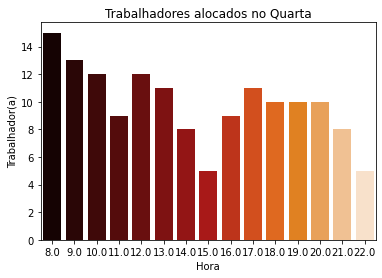

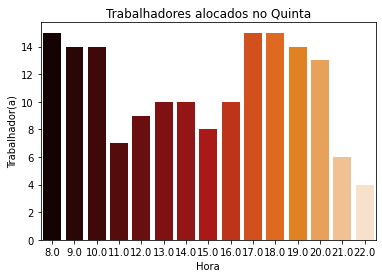

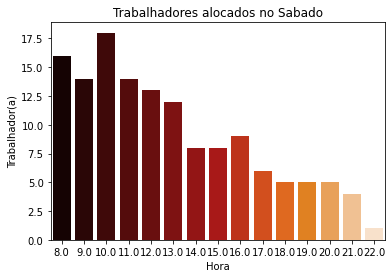

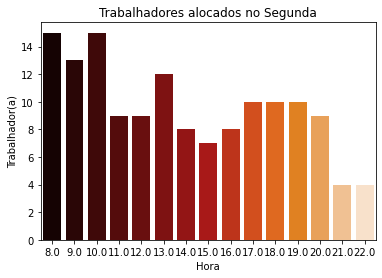

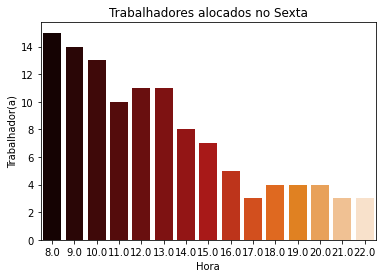

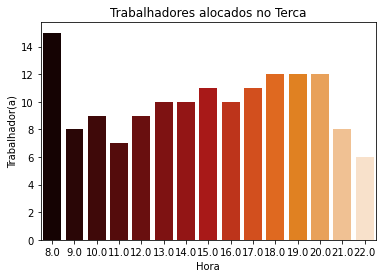

In [ ]:
for dia in trabalhados_alocados_por_hora['Dia'].unique().tolist():
  aux = trabalhados_alocados_por_hora[trabalhados_alocados_por_hora['Dia'] == dia]
  g = sns.barplot(x = 'Hora', y = 'Trabalhador(a)', data = aux, palette = 'gist_heat',)
  g.set_title(f"Trabalhadores alocados no {dia}")
  plt.show()


<Figure size 864x432 with 0 Axes>

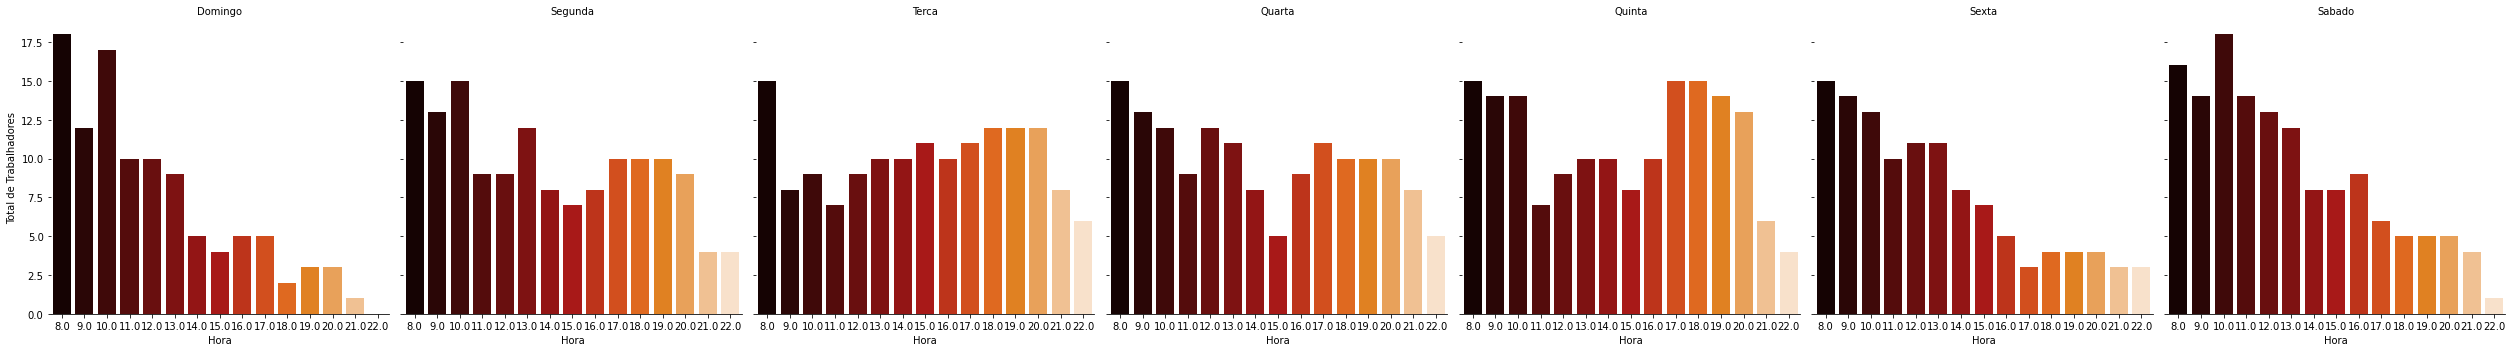

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize = (12,6))
g = sns.catplot(x = 'Hora', y = 'Trabalhador(a)', data = trabalhados_alocados_por_hora.sort_values(by = 'Dia'), 
                  kind = 'bar', col = 'Dia', 
                col_order = ['Domingo','Segunda','Terca','Quarta','Quinta','Sexta','Sabado'], palette = 'gist_heat',
               )
(g.set_axis_labels("Hora", "Total de Trabalhadores")
  .set_titles("{col_name}")
  .despine(left=True))  
plt.show()

## Conclusão
O modelo conseguiu uma boa solução, primeiramente, na qual, conseguimos obter com que os Trabalhadores, mantenham pelo menos um conjunto mínimo de horas trabalhadas;

Além do Fato de conseguimos, com que o laborátorio respeite as restrições de pessoas de acordo com seus respectivos horários;

Para o futuro, adicionar um maior conjunto de restrições, que incluam horários como de reunião/almoço.

Questões de otimização de horários, caso a sua respectiva mesa, não esteja alocada nos horários subsequentes, e o determinado funcionário possua não possua outras restrições de horários preencher com os horarios subsequentes.